# Data Preparation

In [1]:
from __future__ import absolute_import
from numpy import asarray
from numpy import save
from mqt.predictor.driver import Predictor
from mqt.predictor import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

training_data, names_list, scores_list = utils.load_training_data()
X, y = zip(*training_data)
X = list(X)
y = list(y)
for i in range(len(X)):
    X[i] = list(X[i])
    scores_list[i] = list(scores_list[i])


X, y, indices = np.array(X), np.array(y), np.array(range(len(y)))

non_zero_indices = []
for i in range(len(X[0])):
    if sum(X[:, i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]
data = asarray(non_zero_indices)
save("non_zero_indices.npy", data)

(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X, y, indices, test_size=0.3, random_state=5)

scores_filtered = [scores_list[i] for i in indices_test]
names_filtered = [names_list[i] for i in indices_test]

predictor = Predictor()
performance = []

# Random Forest

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


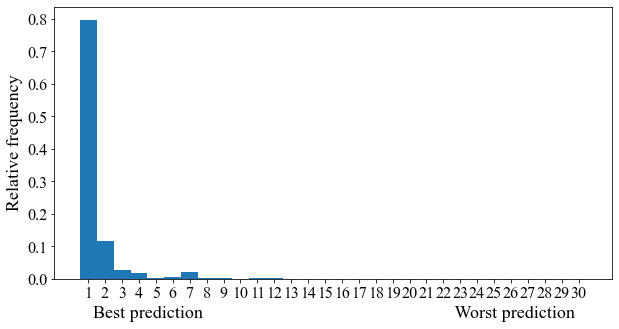

Best Accuracy:  0.764974112511899
Top 3:  0.9428571428571428
Feature Importance:  [4.71472645e-02 7.99072841e-03 3.49605841e-04 7.32689613e-02
 4.56102561e-03 2.93930949e-04 8.89391725e-03 3.24398939e-02
 1.30373182e-03 6.34606971e-03 5.60109704e-03 1.48751183e-02
 2.28169924e-03 2.48334664e-04 5.51960385e-04 3.74365054e-04
 2.39715939e-02 3.59857580e-05 1.20990459e-03 3.78380454e-04
 1.68076944e-01 9.33411378e-02 6.06406596e-02 1.05449242e-01
 1.15335597e-01 1.14758832e-01 1.10274019e-01]


In [2]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(random_state=0)

tree_param = [
    {
        "n_estimators": [100, 200, 500],
        "max_features": ["auto", "sqrt"],
        "max_depth": list(range(8, 30, 6)),
        "min_samples_split": list(range(2, 20, 6)),
        "min_samples_leaf": list(range(2, 20, 6)),
        "bootstrap": [True, False],
    },
]

clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)


y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="RandomForestClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
performance.append(("Random Forest", clf.best_score_, top3, max(res)))

predictor.set_classifier(clf.best_estimator_)
utils.save_classifier(clf.best_estimator_)

### Feature Importances

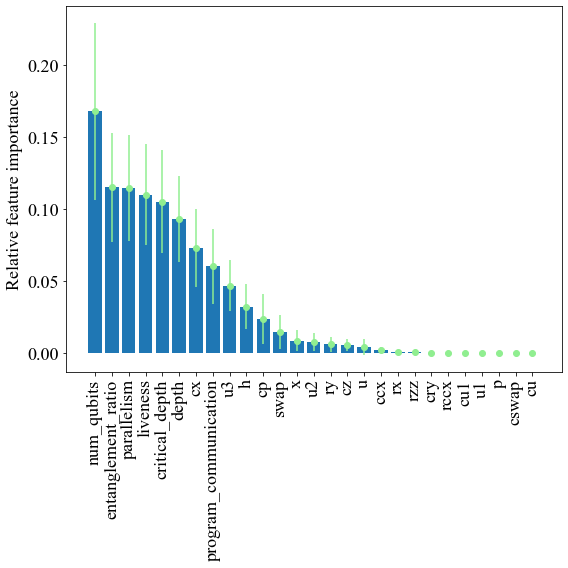

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

openqasm_qc_list = utils.get_openqasm_gates()
feature_names = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
feature_names.append("num_qubits")
feature_names.append("depth")
feature_names.append("program_communication")
feature_names.append("critical_depth")
feature_names.append("entanglement_ratio")
feature_names.append("parallelism")
feature_names.append("liveness")
feature_names = [feature_names[i] for i in non_zero_indices]

importances = clf.best_estimator_.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in clf.best_estimator_.estimators_], axis=0
)

idx = np.argsort(-importances)

plt.figure(figsize=(8, 8))
plt.bar(np.array(feature_names)[idx], np.array(importances)[idx])
plt.errorbar(
    np.array(feature_names)[idx],
    np.array(importances)[idx],
    np.array(std)[idx],
    fmt="o",
    color="lightgreen",
)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Relative feature importance", fontsize=18)
plt.tight_layout()
plt.savefig("results/feature_importances.pdf")
plt.show()

# Entries Graph:  630


/Users/nils/Documents/repos/MQTPredictor/src/mqt/predictor/driver.py:387: RuntimeWarning: overflow encountered in double_scalars
  plt.plot(i, tmp_res[j] / max_score, "b.", alpha=1.0, markersize=1.7)
/Users/nils/Documents/repos/MQTPredictor/src/mqt/predictor/driver.py:391: RuntimeWarning: overflow encountered in double_scalars
  tmp_res[y_pred_sorted_accordingly[i]] / max_score,


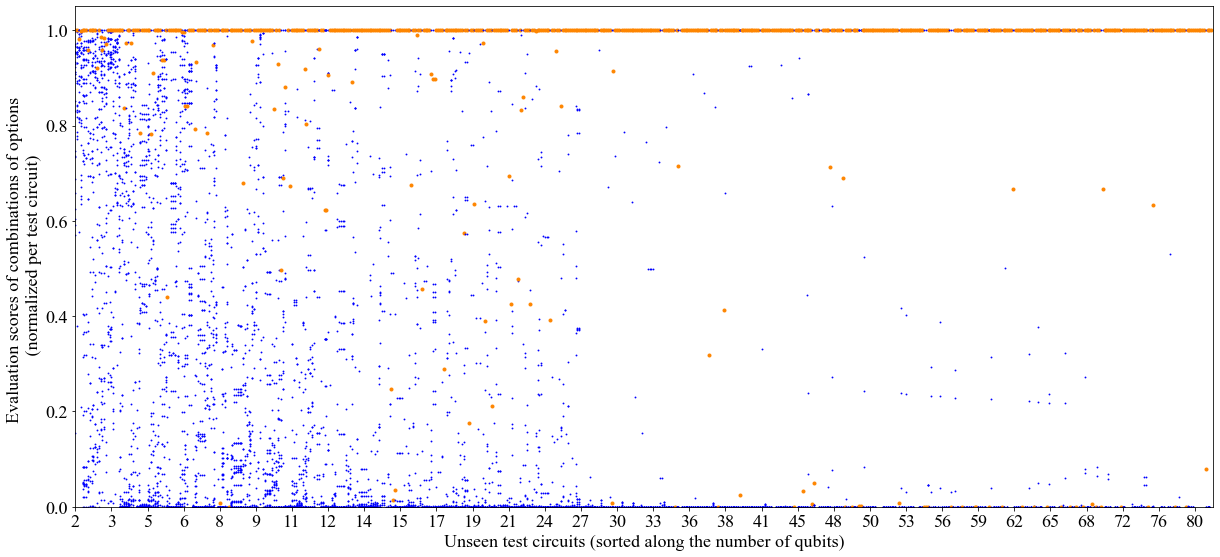

In [4]:
predictor.plot_eval_all_detailed_compact_normed(
    names_filtered, scores_filtered, y_pred, y_test
)

# GradientBoostingClassifier

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


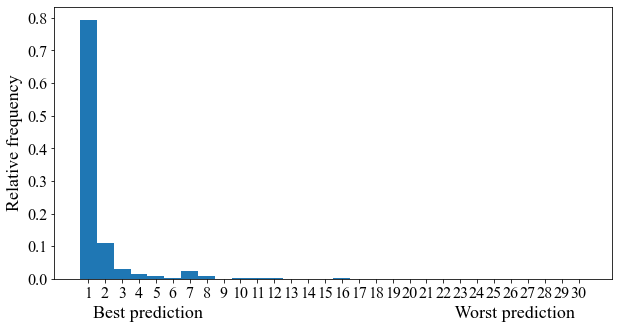

Best Accuracy:  0.7574934410624318
Top 3:  0.9333333333333333


In [5]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

param_grid = {
    "learning_rate": [0.01, 0.1, 1],
}

clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="GradientBoostingClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("Gradient Boosting", clf.best_score_, top3, max(res)))

# Current Decision Tree Classifier

In [6]:
# predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


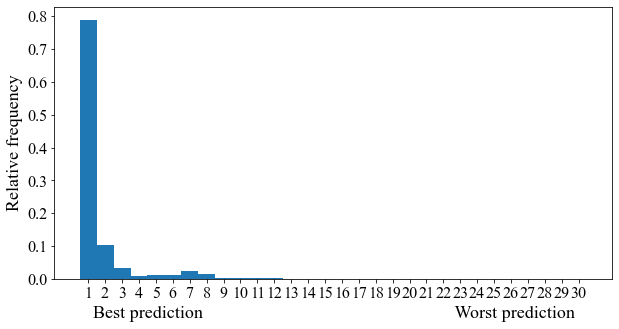

Best Accuracy:  0.7397668965197
Top 3:  0.9238095238095239
Feature Importance:  [0.0114614  0.00219981 0.         0.06642992 0.         0.
 0.00250642 0.01962006 0.00095684 0.         0.         0.
 0.00104792 0.         0.         0.         0.         0.
 0.         0.         0.43893541 0.05903139 0.0309124  0.07913554
 0.09867927 0.11509655 0.07398707]


In [7]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

clf = tree.DecisionTreeClassifier(random_state=5)

tree_param = [
    {
        "criterion": ["entropy", "gini"],
        "max_depth": list(range(1, 15, 1)),
        "min_samples_split": list(range(2, 20, 4)),
        "min_samples_leaf": list(range(2, 20, 4)),
        "max_leaf_nodes": list(range(2, 200, 40)),
        "max_features": list(range(1, len(non_zero_indices), 10)),
    },
]
clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)
y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="DecisionTreeClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
performance.append(("Decision Tree", clf.best_score_, top3, max(res)))

# Nearest Neighbor

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


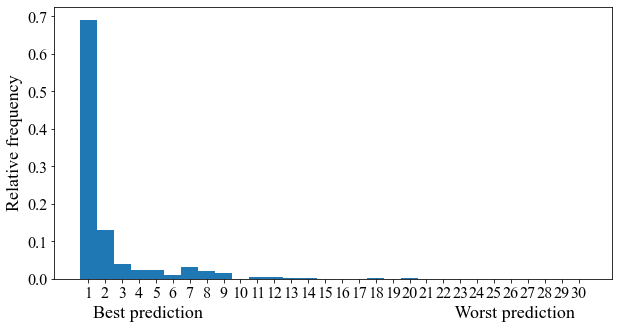

Best Accuracy:  0.6811891992291799
('Top 3: ', 0.8603174603174604)


In [8]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(1, 10, 1))
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="KNeighborsClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print(("Top 3: ", top3))
performance.append(("Nearest Neighbor", clf.best_score_, top3, max(res)))

# MLPClassifier

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nils

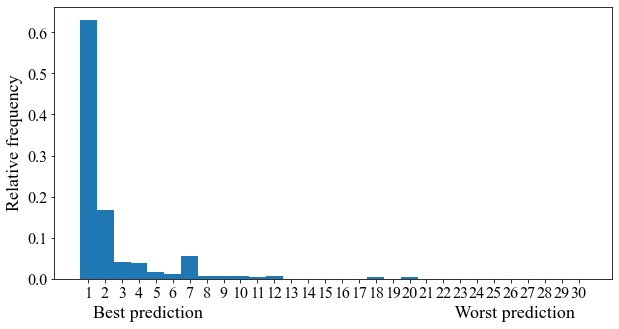

Best Accuracy:  0.6055350467832185
Top 3:  0.8396825396825397


In [9]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier( max_iter=1000)

param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="MLPClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("Multilayer Perceptron", clf.best_score_, top3, max(res)))

# SVM

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


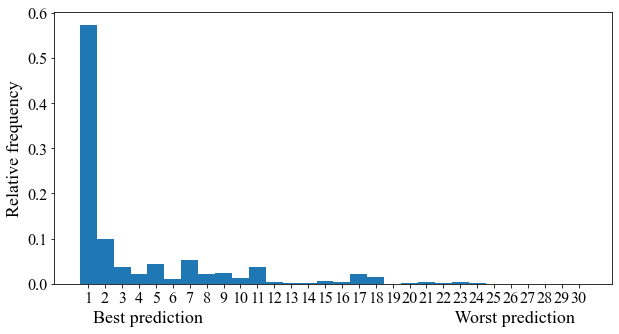

Best Accuracy:  0.5531099811938427
Top 3:  0.7095238095238096


In [10]:
from sklearn import svm

clf = svm.SVC()
param_grid = {"C": [0.1, 1, 10], "gamma": [1, 0.1, 0.01], "kernel": ["rbf", "sigmoid"]}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test, filename="SVM")

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("Support Vector Machine", clf.best_score_, top3, max(res)))

# Naive Bayes

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


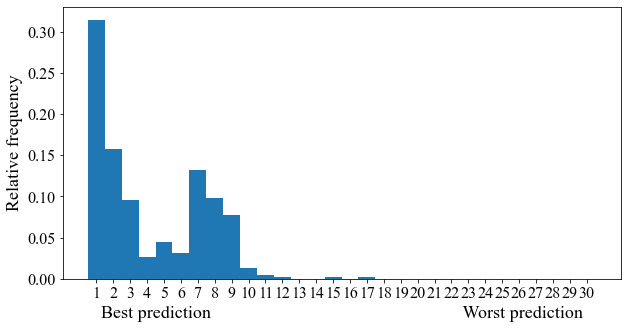

Best Accuracy:  0.28340646838940353
Top 3:  0.5666666666666667


In [11]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
param_grid = {"var_smoothing": np.logspace(0, -9, num=100)}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="GaussianNB"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("Naive Bayes", clf.best_score_, top3, max(res)))

# Save Performance Results

In [12]:
print(performance)

filename = "results/performances.csv"
with open(filename, "w") as f:
    f.write("Algorithm, Accuracy, Top3, Worst Rank\n")
    for sublist in performance:
        line = "{}, {}, {}, {} \n".format(
            sublist[0], sublist[1], sublist[2], sublist[3]
        )
        f.write(line)

[('Random Forest', 0.764974112511899, 0.9428571428571428, 12), ('Gradient Boosting', 0.7574934410624318, 0.9333333333333333, 16), ('Decision Tree', 0.7397668965197, 0.9238095238095239, 12), ('Nearest Neighbor', 0.6811891992291799, 0.8603174603174604, 20), ('Multilayer Perceptron', 0.6055350467832185, 0.8396825396825397, 20), ('Support Vector Machine', 0.5531099811938427, 0.7095238095238096, 24), ('Naive Bayes', 0.28340646838940353, 0.5666666666666667, 17)]


# Run-Time Comparison

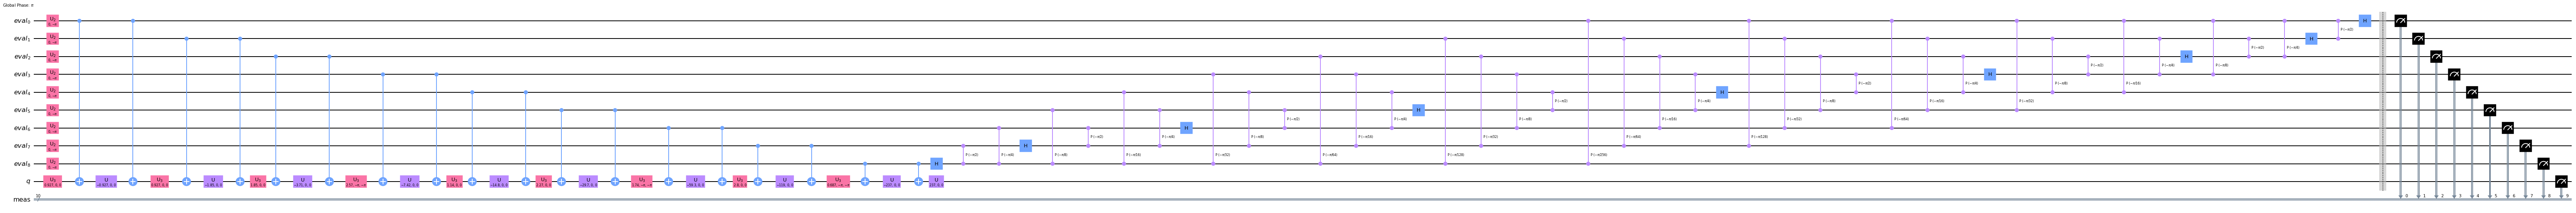

In [4]:
target_path = "/Users/nils/Desktop/runtime_comp/"
from mqt.predictor.driver import Predictor
from mqt.predictor import utils
import numpy as np
from mqt.bench import benchmark_generator

pred = Predictor()
import time

start = time.time()
filename="dj_indep_qiskit_7.qasm"
pred.compile_all_circuits_for_qc(filename = filename, target_path=target_path, timeout=10000)


start_postprocess = time.time()
utils.postprocess_ocr_qasm_files(target_path)
end_postprocess = time.time()
diff_postprocess = (end_postprocess - start_postprocess)

res = pred.generate_training_sample(file = filename, target_path=target_path)
print(res)
end = time.time()

diff_all_compile = (end - start)
print("Overall: ", diff_all_compile)
print("Actually: ", round(diff_all_compile-diff_postprocess,3))
print("Best combination", np.argmax(res[2]))

compile_all_circuits_for_qc: dj_indep_qiskit_7.qasm
New qasm file for:  /Users/nils/Desktop/runtime_comp/dj_indep_qiskit_7_28.qasm
New qasm file for:  /Users/nils/Desktop/runtime_comp/dj_indep_qiskit_7_24.qasm
New qasm file for:  /Users/nils/Desktop/runtime_comp/dj_indep_qiskit_7_25.qasm
New qasm file for:  /Users/nils/Desktop/runtime_comp/dj_indep_qiskit_7_29.qasm
New qasm file for:  /Users/nils/Desktop/runtime_comp/dj_indep_qiskit_7_26.qasm
New qasm file for:  /Users/nils/Desktop/runtime_comp/dj_indep_qiskit_7_27.qasm
Checking  dj_indep_qiskit_7.qasm
(([0, 9, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 1.0, 1.1666666666666667, 0.23076923076923078, 0.3148148148148148, 2.888888888888889], 20), 'dj_indep_qiskit_7', [0.4318759674767895, 0.44471000571087893, 0.44471000571087893, 0.6092445238827421, 0.5851318046823915, 0.3039463467544102, 0.5744455023444768, 0.6069371132277095, 0.6344475165230338, 0.722891207

In [5]:
start = time.time()
prediction = pred.predict("training_samples/" + filename)
print(utils.get_index_to_comppath_LUT()[prediction])
pred.compile_predicted_compilation_path("training_samples/" + filename, prediction)
end = time.time()

diff_predictor = round((end - start),3)
print("Prediction", prediction)
print(diff_predictor)

('ionq', 'ionq11', 'qiskit', 2)
Reading from .qasm path:  training_samples/dj_indep_qiskit_7.qasm

Prediction 20
0.225
